In [1]:
import copy
import json
import os, glob

from itertools import product

import numpy as np
import pandas as pd

import torch
# %matplotlib inline

import torchaudio

from torchaudio.functional.filtering import lowpass_biquad, highpass_biquad
from torchaudio.transforms import Spectrogram, MelSpectrogram, Resample

from matplotlib import rcParams

from collections import defaultdict

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm import tqdm

from src.model.model import DecoderOnlyNetwork
from src.synth.parameters_normalizer import Normalizer
from src.model.loss import spectral_loss
from synth.synth_architecture import SynthModular
# from config import SynthConfig
from src.main_hp_search_dec_only import configure_experiment

# from config import configure_experiment
from dataset.ai_synth_dataset import AiSynthDataset
from synth.synth_constants import synth_constants

%matplotlib inline
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Setup experiment

exp_name = 'training_visualization_fm_saw'
dataset_name = 'fm_saw_single'
config_name = r'C:\Users\noamk\PycharmProjects\ai_synth\configs\lfo_saw_single_synth_config_hp_search.yaml'
device = 'cuda'

cfg = configure_experiment(exp_name, dataset_name, config_name, debug=True)

synth = SynthModular(preset_name=cfg.synth.preset,
                     synth_constants=synth_constants,
                     device=device)

decoder_net = DecoderOnlyNetwork(preset=cfg.synth.preset, device=device)
normalizer = Normalizer(cfg.synth.note_off_time, cfg.synth.signal_duration, synth_constants)

Deleting previous experiment...


In [3]:
cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset=cfg.loss.preset,
                                          synth_constants=synth_constants, device=device)

params_loss_handler = torch.nn.MSELoss()

loss_handler.spectrogram_ops

{'2048_spectrogram': Spectrogram(),
 '1024_spectrogram': Spectrogram(),
 '512_spectrogram': Spectrogram(),
 '256_spectrogram': Spectrogram(),
 '128_spectrogram': Spectrogram(),
 '64_spectrogram': Spectrogram()}

target parameters full range: 
{(1, 1): {'operation': 'lfo', 'parameters': {'active': True, 'output': [(0, 2)], 'freq': 14.285357442943784, 'waveform': 'square'}}, (0, 2): {'operation': 'fm_saw', 'parameters': {'fm_active': True, 'active': True, 'amp_c': 0.6187255599871848, 'freq_c': 349.22823143300377, 'mod_index': 0.02403950683025824}}}
target parameters 0-1: 
{(1, 1): {'operation': 'lfo', 'parameters': {'active': tensor([[-1000.]], device='cuda:0'), 'output': [[(-1, -1)]], 'freq': tensor([0.9507], device='cuda:0'), 'waveform': tensor([[   0., 1000.,    0.]], device='cuda:0')}}, (0, 2): {'operation': 'fm_saw', 'parameters': {'fm_active': tensor([[-1000.]], device='cuda:0'), 'active': tensor([[-1000.]], device='cuda:0'), 'amp_c': tensor([0.6187], device='cuda:0'), 'freq_c': tensor([0.1523], device='cuda:0'), 'mod_index': tensor([0.1560], device='cuda:0')}}}


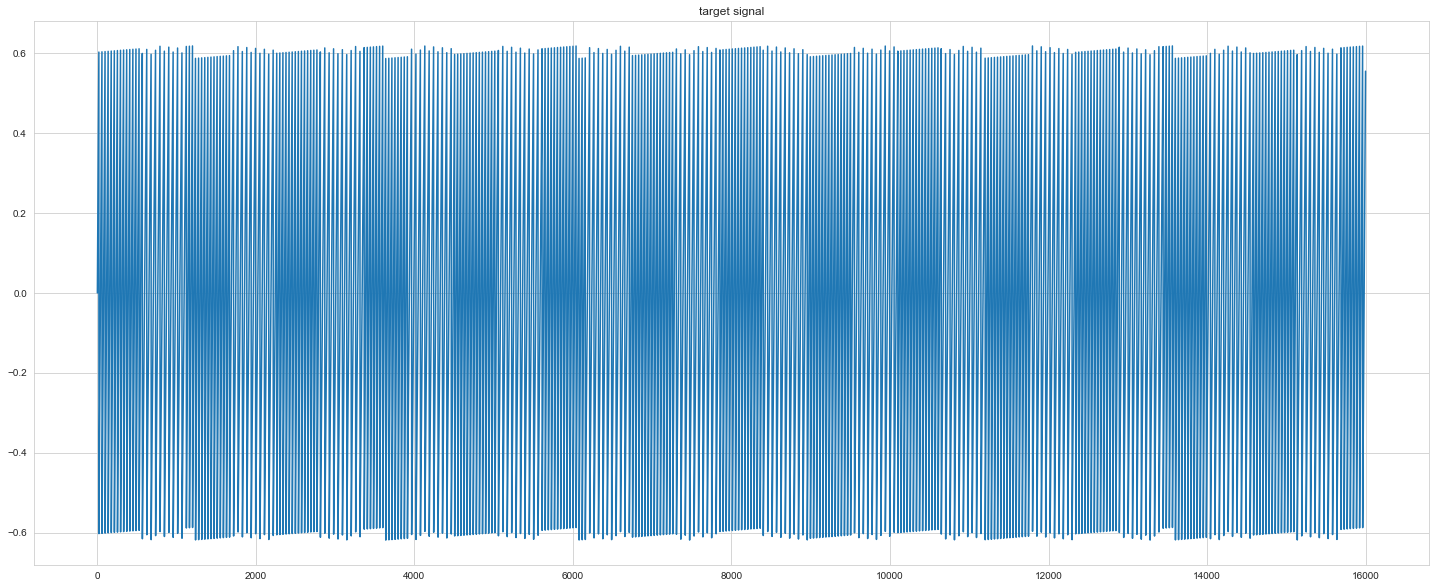

C:\Users\noamk\PycharmProjects\ai_synth\src\model\model.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  SimpleWeightLayer(torch.tensor(init_values['freq'],
C:\Users\noamk\PycharmProjects\ai_synth\src\model\model.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  SimpleWeightLayer(torch.tensor(init_values['waveform'],
C:\Users\noamk\PycharmProjects\ai_synth\src\model\model.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  SimpleWeightLayer(torch.tensor(init_values[fm_param], dtype=torch.float, device=self.device,
C:\Users\noamk\P

decoder_net output: 
 {(1, 1): {'operation': 'lfo', 'parameters': {'freq': Parameter containing:
tensor([[0.9507]], device='cuda:0'), 'active': Parameter containing:
tensor([[-1000.]], device='cuda:0'), 'waveform': Parameter containing:
tensor([[   0., 1000.,    0.]], device='cuda:0')}}, (0, 2): {'operation': 'fm_saw', 'parameters': {'amp_c': Parameter containing:
tensor([[0.6187]], device='cuda:0'), 'freq_c': Parameter containing:
tensor([[0.1523]], device='cuda:0', requires_grad=True), 'mod_index': Parameter containing:
tensor([[0.1560]], device='cuda:0'), 'active': Parameter containing:
tensor([[-1000.]], device='cuda:0'), 'fm_active': Parameter containing:
tensor([[-1000.]], device='cuda:0')}}}
decoder_net output full range: 
 {(1, 1): {'operation': 'lfo', 'parameters': {'freq': tensor([[14.2854]], device='cuda:0'), 'active': Parameter containing:
tensor([[-1000.]], device='cuda:0'), 'waveform': Parameter containing:
tensor([[   0., 1000.,    0.]], device='cuda:0')}}, (0, 2): {'ope

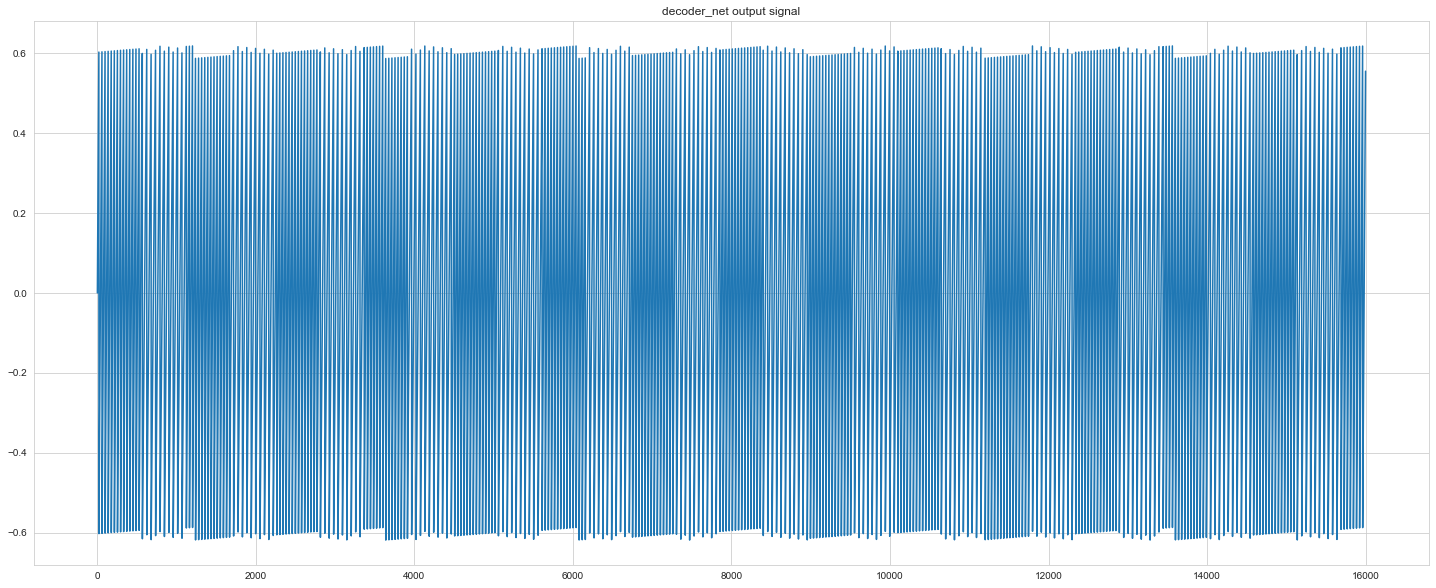

In [4]:
dataset = AiSynthDataset(r'C:\Users\noamk\PycharmProjects\ai_synth\data\lfo_saw_single\train', noise_std=0)

target_sample = dataset[0]
target_signal, target_param_dict, signal_index = target_sample

print(f"target parameters full range: \n{target_param_dict}")

target_param_dict = {(1, 1): {'operation': 'lfo',
                            'parameters': {'active': torch.tensor([[-1000.0]], device=device),
                                           'output': [[(-1, -1)]],
                                           'freq': torch.tensor([14.285357442943784], device=device),
                                           'waveform': torch.tensor([[0., 1000.0, 0.]], device=device)}},
                   (0, 2): {'operation': 'fm_saw',
                            'parameters': {'fm_active': torch.tensor([[-1000.0]], device=device),
                                           'active': torch.tensor([[-1000.0]], device=device),
                                           'amp_c': torch.tensor([0.6187255599871848], device=device),
                                           'freq_c': torch.tensor([349.22823143300377], device=device),
                                           'mod_index': torch.tensor([0.02403950683025824], device=device)}}}

target_params_01 = normalizer.normalize(target_param_dict)
print(f"target parameters 0-1: \n{target_params_01}")

plt.figure(figsize=(25, 10))
plt.title("target signal")
plt.plot(target_signal.detach().numpy().squeeze())
plt.show()

decoder_net.apply_params(target_params_01)

parameters_to_freeze = {(1, 1): {'operation': 'lfo',
                                      'parameters': ['freq', 'waveform', 'active']},
                        (0, 2): {'operation': 'fm_saw',
                                 'parameters': ['active', 'fm_active', 'amp_c', 'mod_index']}}

decoder_net.freeze_params(parameters_to_freeze)


predicted_params_01 = decoder_net()
print(f"decoder_net output: \n {predicted_params_01}")

predicted_params_full_range = normalizer.denormalize(predicted_params_01)
print(f"decoder_net output full range: \n {predicted_params_full_range}")

synth.update_cells_from_dict(predicted_params_full_range)
generated_target_signal, _ = synth.generate_signal(signal_duration=1, batch_size=1)

plt.figure(figsize=(25, 10))
plt.title("decoder_net output signal")
plt.plot(generated_target_signal.cpu().detach().numpy().squeeze())
plt.show()

In [30]:
from tqdm import tqdm

cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset="mag_logmag",
                                          synth_constants=synth_constants, device=device)

fm_freq_vals = np.linspace(0, 2000, 20000)

losses = []
for freq_val in tqdm(fm_freq_vals):
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'freq_c': freq_val})

    synth.update_cells_from_dict(update_params)
    generated_signal, _ = synth.generate_signal(signal_duration=1)

    target_signal_unsqueezed = target_signal.to(device).unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, generated_signal, step=0, return_spectrogram=False)

    losses.append(loss_val.detach().cpu().numpy().item())

plt.figure(figsize=(25, 5))
plt.plot(fm_freq_vals, losses)

100%|██████████| 20000/20000 [02:24<00:00, 138.40it/s]


<IPython.core.display.Javascript object>

In [39]:
num_epochs = 200
starting_frequency = 0.155
decoder_net.apply_params_partial({(0, 2):
                                     {'operation': 'fm_saw',
                                      'parameters': {'freq_c': starting_frequency}
                                     }
                                 })

base_lr = 1e-3
optimizer = torch.optim.Adamax(decoder_net.parameters())

train_res = []
for e in range(num_epochs):

    predicted_params_01 = decoder_net.forward()
    # print(f"decoder_net output: \n {predicted_params_01}")

    predicted_params_full_range = normalizer.denormalize(predicted_params_01)
    predicted_freq = predicted_params_full_range[(0, 2)]['parameters']['freq_c']
    # print(f"decoder_net output full range: \n {predicted_params_full_range}")

    synth.update_cells_from_dict(predicted_params_full_range)
    predicted_signal, _ = synth.generate_signal(signal_duration=1)

    # plt.figure(figsize=(25, 10))
    # plt.plot(target_signal.detach().numpy().squeeze())
    # plt.plot(predicted_signal.cpu().detach().numpy().squeeze())
    # plt.show()

    target_signal_unsqueezed = target_signal.to(device).unsqueeze(dim=0)
    loss, _, _ = loss_handler.call(target_signal_unsqueezed, predicted_signal, step=e)
    # print(f"loss: {loss.item()}")

    # loss = params_loss_handler(predicted_params_01[(0, 2)]['parameters']['freq_c'], torch.tensor(0.15).cuda())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_res.append((e, predicted_freq.item(), loss.item(), decoder_net.parameters_dict[decoder_net.get_key((0, 2), 'fm_saw', 'freq_c')].weight.grad))
    print(decoder_net.parameters_dict[decoder_net.get_key((0, 2), 'fm_saw', 'freq_c')].weight.grad)


tensor(-839.3939, device='cuda:0')
tensor(146.0146, device='cuda:0')
tensor(-98.5501, device='cuda:0')
tensor(486.7198, device='cuda:0')
tensor(43.3868, device='cuda:0')
tensor(-118.5110, device='cuda:0')
tensor(396.6865, device='cuda:0')
tensor(-1289.4189, device='cuda:0')
tensor(-795.0670, device='cuda:0')
tensor(-70.0013, device='cuda:0')
tensor(900.5251, device='cuda:0')
tensor(-163.4907, device='cuda:0')
tensor(-593.5977, device='cuda:0')
tensor(291.7426, device='cuda:0')
tensor(-320.1797, device='cuda:0')
tensor(-69.9386, device='cuda:0')
tensor(-377.2157, device='cuda:0')
tensor(762.5858, device='cuda:0')
tensor(628.9601, device='cuda:0')
tensor(746.9203, device='cuda:0')
tensor(247.1866, device='cuda:0')
tensor(45.1366, device='cuda:0')
tensor(72.9388, device='cuda:0')
tensor(-117.5646, device='cuda:0')
tensor(-152.0953, device='cuda:0')
tensor(-41.4432, device='cuda:0')
tensor(-89.6792, device='cuda:0')
tensor(633.6940, device='cuda:0')
tensor(-348.1134, device='cuda:0')
tenso

In [40]:
%matplotlib notebook
from matplotlib import animation

fig, ax = plt.subplots(figsize=(25, 5))
l1, = ax.plot(fm_freq_vals, losses, 'o-', label='loss surface', markevery=[-1])
l2, = ax.plot([], [], 'o-', label='training progress')
ax.legend(loc='center right')
# ax.set_xlim(0,100)
# ax.set_ylim(0,1)


def animate(i):
    xi = [train_res[j][1] for j in range(i)]
    yi = [train_res[j][2] for j in range(i)]
    l2.set_data(xi, yi)
    return (l2)

animation.FuncAnimation(fig, animate, frames=num_epochs, interval=500)

<IPython.core.display.Javascript object>